## Mettre à jour les données source

- accéder à la page : https://www.facebook.com/groups/Covoit.Libre.Fr.le.groupe/post_tags_list
- copier-coller les lignes avec "Départ …" et le nombre de publications et les placer dans un fichier `mbc.txt`

In [1]:
!echo "Département,Ville,Total" > mbc.csv
!cat mbc.txt |\
     sed -e 's_^Départ __g' \
         -e 's_\(.*\)(\(.*\))\(.*\)_\2,\1_' |\
     sed -e '{:a;N;$!ba;s_\n_,_g};s_$_,_' \
         -e 's_publications*,_\n_g' |\
     sed -n '/^[^,]*,[^,]*,[^,]*$/p' \
     >> mbc.csv

## Exploration préalable

In [2]:
from pandas import read_csv

In [3]:
data = read_csv("mbc.csv").set_index(["Département"]).fillna(0)

In [4]:
data

Ville  Total
Département                           
75           Paris intra-muros      50
31               Haute-Garonne      41
69                       Rhône      39
35             Ille-et-Vilaine      27
59                        Nord      27
...                         ...    ...
41                Loir-et-Cher       0
32                        Gers       0
43                 Haute-Loire       0
2B                 Haute-Corse       0
05                Hautes-Alpes       0

[113 rows x 2 columns]

#### Nombre d'annonces classifiées

In [5]:
data.Total.sum()

855

### Point GPS par département

L'IGN fournit le point GPS de la préfecture de chaque département.

Récupérons une table d'association `département - point GPS de la préfecture`

In [6]:
!wget https://www.data.gouv.fr/en/datasets/r/8603852d-9ae4-4a32-b65f-d5800106e985 -O departements.csv

--2020-09-01 13:09:14--  https://www.data.gouv.fr/en/datasets/r/8603852d-9ae4-4a32-b65f-d5800106e985
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.93
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://static.data.gouv.fr/resources/liste-des-departements-francais-metropolitains-doutre-mer-et-les-com-ainsi-que-leurs-prefectures/20200808-122644/liste-dpt-drom-com.csv [following]
--2020-09-01 13:09:15--  https://static.data.gouv.fr/resources/liste-des-departements-francais-metropolitains-doutre-mer-et-les-com-ainsi-que-leurs-prefectures/20200808-122644/liste-dpt-drom-com.csv
Resolving static.data.gouv.fr (static.data.gouv.fr)... 37.59.183.93
Connecting to static.data.gouv.fr (static.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5729 (5.6K) [text/csv]
Saving to: ‘departements.csv’

departements.csv    100%[===================>

In [7]:
departements = read_csv("departements.csv").set_index(["code"])

In [12]:
departements.loc["1"]

type                              DPT
nom                               Ain
chefLieu              Bourg-en-Bresse
region           Auvergne-Rhône-Alpes
debutValidite                22/03/20
finValidite                       NaN
Name: 1, dtype: object

Cela nous donne la préfecture pour chaque département.

Il reste à récupérer la position GPS pour la préfecture.

In [13]:
from pandas import DataFrame

In [14]:
gps_list = []

for row in departements.iterrows():
    city = row[1].chefLieu
    dep_code = row[0]
    !if [ ! -f cities/"$city".json ] ;then wget https://nominatim.openstreetmap.org/search/"$city"?format=json -O cities/"$city".json 2>> /tmp/err;fi
    
    lat = !cat cities/"$city".json |jq '.[0].lat' | sed 's_"__g'
    lon = !cat cities/"$city".json |jq '.[0].lon' | sed 's_"__g'
    
    try:
        gps_list.append({
            "city": city,
            "dep_code": dep_code,
            "pref_lat": lat[0],
            "pref_lon": lon[0]
        })

    except:
        print(city)

In [15]:
gps = DataFrame(gps_list).set_index(["dep_code"])

In [16]:
import geopandas as gpd
from matplotlib import pyplot as plt

In [17]:
gdf = gpd.GeoDataFrame(
    gps, geometry=gpd.points_from_xy(gps.pref_lon, gps.pref_lat))

In [18]:
gdf.head(3)

city    pref_lat   pref_lon                  geometry
dep_code                                                                  
1         Bourg-en-Bresse  46.2051192  5.2250324  POINT (5.22503 46.20512)
2                    Laon   49.564665   3.620686  POINT (3.62069 49.56466)
3                 Moulins     49.4217     3.6847  POINT (3.68470 49.42170)

In [19]:
gps["Total"] = data["Total"]

## Visualisation dans l'espace

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

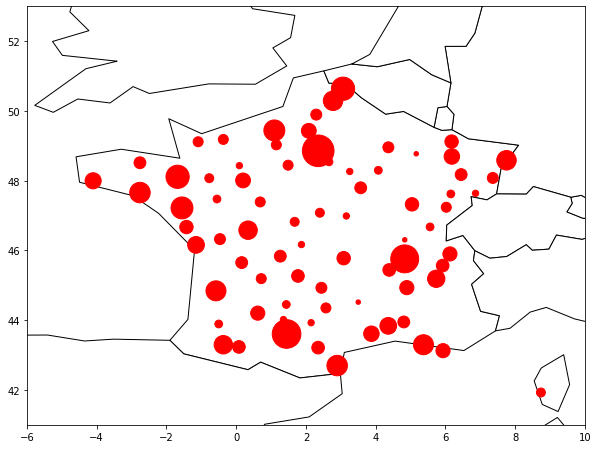

In [21]:
ax = world.plot(color='white', edgecolor='black', figsize=(10,10))
ax.set_xlim(-6,10)
ax.set_ylim(41,53)

gdf.plot(ax=ax, color='red', markersize = gps.Total * 20)

from datetime import datetime
today_filename = "images/departement-de-depart-{}.png".format(datetime.strftime(datetime.now(), "%Y-%m-%d"))

plt.savefig(today_filename)

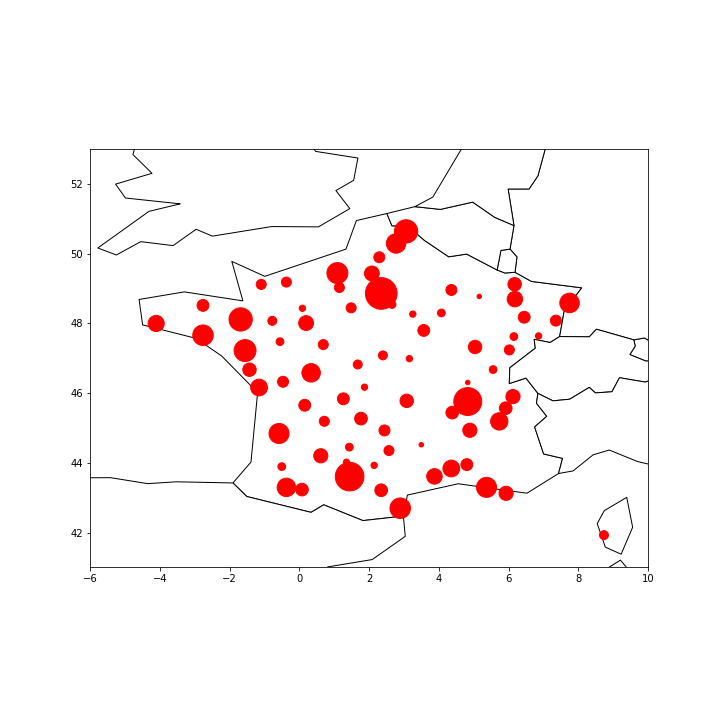

In [22]:
from IPython.display import Image
Image(today_filename)

In [23]:
!convert -delay 30  -size 100x100 -loop 0 images/departement-de-depart-* departement-de-depart.gif